In [1]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots, Printf
using Plots.PlotMeasures
using ProgressBars
include("plotting.jl")
include("petrels.jl")
include("grouse.jl")
include("shasta1.jl")
include("shasta2.jl")
include("batchHPPCACompletion.jl")

updatev! (generic function with 1 method)

In [2]:
function Ωloglikelihood(M::HePPCATModel,Y, Ω)
    d, k = size(M.U)
    n, L = size.(Y,2), length(Y)
    
    value = 0
    for l=1:L
        for i=1:n[l]
            idx = findall(>(0), Ω[l][:,i])
            yΩ = Y[l][idx,i]
            FΩ = M.F[idx,:]
            FΩsvd = svd(FΩ)
            value += norm(sqrt(Diagonal((FΩsvd.S./M.v[l])./(FΩsvd.S .+ M.v[l])))*FΩsvd.U'*yΩ)^2 -
                        sum(log.(FΩsvd.S .+ M.v[l])) - (length(idx)-k)*log(M.v[l]) - norm(yΩ)^2/M.v[l]
        end
    end
    return 1/2*value
    
end

Ωloglikelihood (generic function with 1 method)

In [3]:
function Ωloglikelihood2(M::HePPCATModel,Y, Ω)
    d, k = size(M.U)
    n, L = size.(Y,2), length(Y)
    
    return 1/2*sum(1:L) do l
        sum(1:n[l]) do i
            idx = findall(>(0), Ω[l][:,i])
            yΩ = Y[l][idx,i]
            FΩ = M.F[idx,:]
            FΩsvd = svd(FΩ)
            norm(sqrt(Diagonal((FΩsvd.S./M.v[l])./(FΩsvd.S .+ M.v[l])))*FΩsvd.U'*yΩ)^2 -
                        sum(log.(FΩsvd.S .+ M.v[l])) - (length(idx)-k)*log(M.v[l]) - norm(yΩ)^2/M.v[l]
        end
    end
    
end

Ωloglikelihood2 (generic function with 1 method)

In [4]:
# Ωloglikelihood(Mppca,Ytrue,Ω)
# Ωloglikelihood2(Mppca,Ytrue,Ω)
# method1 = []
# method2 = []
# for _=1:100
    
#     telapsed = @elapsed begin
#         Ωloglikelihood(Mppca,Ytrue,Ω)
#     end
#     push!(method1,telapsed)
    
#     telapsed = @elapsed begin
#         Ωloglikelihood2(Mppca,Ytrue,Ω)
#     end
#     push!(method2,telapsed)
    
# end

In [5]:
# mean(method1)

In [6]:
# mean(method2)

In [7]:
# Ωloglikelihood(Mppca,Ytrue,Ω)

In [8]:
# loglikelihood(Mppca,Ytrue)

### Batch vs. Streaming on missing data: Static subspace

In [9]:
d, n, v, λ = 100, [500,2000], [1e-4,1e-2], [4,2,1]

# d, n, v, λ = 100, [5000,20000], [1e-4,1e-2], [4,2,1]

k, L = length(λ), length(v)
khat = k;

# num_trials = 10
num_trials = 1

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))


missing = 0
# missing = 0.5
# missing = 0.8
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ytrue[l] for l in 1:L]

### Streaming-setup
Ymat_true = hcat([Ytrue[l] for l=1:L]...)
Ymat = hcat([Y[l] for l=1:L]...)
vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
ΩY = abs.(Ymat) .> 0

dataIdx = randperm(sum(n))
Ymat = Ymat[:,dataIdx]
Ymat_true = Ymat_true[:,dataIdx]
ΩY = ΩY[:,dataIdx]
groups = groups[dataIdx]

### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

# Ltrue = loglikelihood(Mtrue,Ytrue)
# stats_fcn(M) = loglikelihood(M,Ytrue) - Ltrue

# Ltrue = Ωloglikelihood(Mtrue,Ytrue,Ω)
# stats_fcn(M) = Ωloglikelihood(M,Ytrue,Ω) - Ltrue

Ltrue = Ωloglikelihood2(Mtrue,Ytrue,Ω)
stats_fcn(M) = Ωloglikelihood2(M,Ytrue,Ω) - Ltrue

stats_fcn (generic function with 1 method)

In [10]:
function Fmeasure(M)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
    
#     return norm(M.F*M.F' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

Fmeasure (generic function with 1 method)

In [11]:
### HePPCAT (Batch)
heppcat_time_log = []
for _=1:1
    tHeppcat = @elapsed begin
        Mheppcat = heppcat(Y,k,100) 
    end
    push!(heppcat_time_log,tHeppcat)
end
tHeppcat = median(heppcat_time_log)
Mheppcat = heppcat(Y,k,100) 

### Homoscedastic PPCA
cor = sum(Y[l]*Y[l]' for l in 1:L)/sum(n)
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))

HePPCATModel{Float64, Float64}([-0.1373682031343777 0.04924851289098967 0.10506205815607765; -0.15338637789140802 -0.038902990213771235 0.06962085032038318; … ; -0.11948644342264647 0.0063426184871220315 -0.11356708711063138; -0.14733527538574348 -0.06666941387801797 0.10050273791745863], [4.064662063739163, 1.9909988868925206, 0.9909105123476535], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [0.007960249595696904, 0.007960249595696904])

In [12]:
# stats_fcn(M) = M.v

##### Batch algorithm

In [13]:
include("batchHPPCACompletion.jl")

updatev! (generic function with 1 method)

In [14]:
batch_stats_trials = []
batch_err_trials = []
batch_time_trials = []
batch_models = []
niters = 900

Mbatch = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,1,Fmeasure,stats_fcn)

# Random.seed!(0)
for _=1:1
    Mbatch = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
#     Mbatch = deepcopy(Mppca)
    Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,niters,Fmeasure,stats_fcn)
    push!(batch_stats_trials,batch_stats_log)
    push!(batch_err_trials,batch_err_log)
    push!(batch_time_trials,batch_time_log)
    push!(batch_models,Mbatch)
end

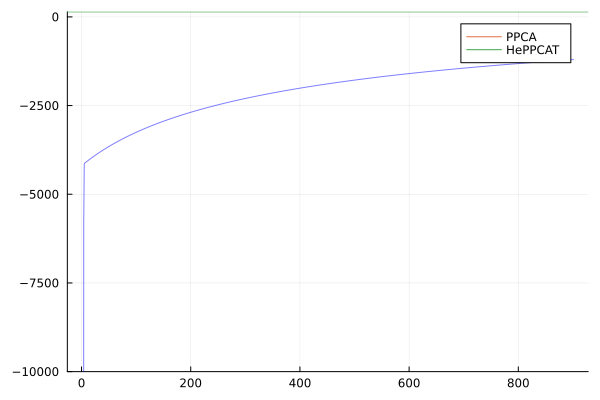

In [15]:
plot()
[plot!(trial, label="",color=:blue,alpha=0.5) for trial in batch_stats_trials]
hline!([stats_fcn(Mppca)],label="PPCA")
hline!([stats_fcn(Mheppcat)],label="HePPCAT")
ylims!(-1e4,Inf)

In [16]:
loglikelihood(Mbatch,Y)

541545.9245612976

In [17]:
loglikelihood(Mheppcat,Y)

543078.7014069097

In [18]:
Mheppcat.λ

3-element Vector{Float64}:
 4.064942247488087
 1.9912212482735907
 0.9910805400633552

In [19]:
Mbatch.λ

3-element Vector{Float64}:
 1.5985773996935182
 0.8629588685246073
 0.6180214476334028


##### SHASTA-PCA-2

In [20]:
include("shasta2.jl")

updateLogLikelihood! (generic function with 1 method)

In [21]:
mutable struct LearningRateParams
    w::Float64
    cf::Float64
    cv::Float64
end

In [22]:
shasta_stats_trials = []
shasta_err_trials = []
shasta_time_trials = []
shasta_models = []

# w = 0.001
w = 1
# cf = 0.5
# cf = 0.1 ### 75%

# cf = 0.01 ###fully-observed - 50%
# cv = 1

cf = 0.1
cv = 0.1
# cv = 1

num_trials = 1

# cv = 0.1
δ = 0.1
online = false


# w = 0.01
# # cf = 0.01
# cf = 0.01
# cv = 0.01
# online = true


lrparams = LearningRateParams(w,cf,cv)
Yrec = deepcopy(Ymat)

### Compile the function on a dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream = deepcopy(M0)
Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA2(Mstream,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn,online,10000)

Random.seed!(0)
for _=1:num_trials
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
#     Mstream = deepcopy(M0)
    Mstream = deepcopy(Mppca)
    Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA2(Mstream,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn,online,250)
    push!(shasta_stats_trials,stats_log)
    push!(shasta_err_trials,err_log)
    push!(shasta_time_trials,time_log)
    push!(shasta_models,Mstream)
end

##### SHASTA-PCA-1

In [23]:
shasta2_stats_trials = []
shasta2_err_trials = []
shasta2_time_trials = []
shasta2_models = []

# w = 0.001
# w = 1
# cf = 1
# cv = 1
Yrec = deepcopy(Ymat)

δ = 0.1

lrparams = LearningRateParams(w,cf,cv)

### Compile the function on a dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream2 = deepcopy(M0)
Mstream2, Yrec2, stats_log2, err_log2, time_log2 = SHASTA_PCA1(Mstream2,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn,online,10000)

Random.seed!(0)
for _=1:num_trials
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
#     M0 = HePPCATModel(U,λ,I(k),rand(L))
#     Mstream2 = deepcopy(M0)
    Mstream2 = deepcopy(Mppca)
    Mstream2, Yrec2, stats_log2, err_log2, time_log2 = SHASTA_PCA1(Mstream2,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn,online,250)
    push!(shasta2_stats_trials,stats_log2)
    push!(shasta2_err_trials,err_log2)
    push!(shasta2_time_trials,time_log2)
    push!(shasta2_models,Mstream2)
end

In [24]:
include("plotting.jl")

plottimetraces (generic function with 3 methods)

In [25]:
stats = [shasta2_stats_trials,shasta_stats_trials,batch_stats_trials]
errs = [shasta2_err_trials,shasta_err_trials,batch_err_trials]
times = [shasta2_time_trials,shasta_time_trials,batch_time_trials]
labels = ["SHASTA-PCA-1","SHASTA-PCA-2","Batch method"]
colors = Dict("SHASTA-PCA-1"=>:lightblue,"SHASTA-PCA-2"=>:blue,"Batch method"=>:black)
markers = Dict("SHASTA-PCA-1"=>:circ,"SHASTA-PCA-2"=>:diamond,"Batch method"=>:rect)
# interval = Dict("SHASTA-PCA-1"=>1000,"SHASTA-PCA-2"=>1000,"Batch method"=>1)
interval = Dict("SHASTA-PCA-1"=>2,"SHASTA-PCA-2"=>2,"Batch method"=>1)

Dict{String, Int64} with 3 entries:
  "SHASTA-PCA-1" => 2
  "SHASTA-PCA-2" => 2
  "Batch method" => 1

In [26]:
missing_rate = Int(round((1-missing)*100))
# interval = [1000, 1]
alph = 0.05
fontsize = 10
figsize = (400,300)

# p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,"Subspace Error: $missing_rate % observed","Iteration",:outerright,:log)
# hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

# figsize = (400,300)
# # colors = Dict("SHASTA-PCA-2"=>:blue)
# p2 = plottraces(stats,labels,colors,markers,interval,alpha,figsize,fontsize,"Log-likelihood: $missing_rate % observed","Iteration",false,:linear)
# hline!(p2,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p2,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

# ylims!(p2,(-1e5,1e4))
# p = plot(p2,p1,layout = @layout([q1{0.38w} q2]),size=(700,300),bottom_margin=5mm)
# # p = plot(p1,p2,layout = @layout([q1{0.5w} q2]),size=(800,300),bottom_margin=5mm)

# # file = "shasta_results/online_algs_iteration-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# # savefig(p,file)
# plot(p)

(400, 300)

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/kgilman/.julia/packages/Plots/GGa6i/src/axes.jl:76


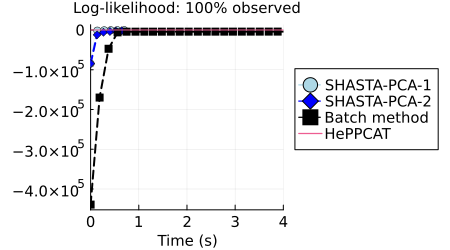

In [27]:
missing_rate = Int(round((1-missing)*100))
p1 = plottimetraces(stats,times,labels,colors,markers,interval,alph,figsize,fontsize,"Log-likelihood: $missing_rate% observed","Time (s)",:outerright)
# hline!(p1,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p1,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")
xlims!(0,4)
# xlims!(0,3)
# xlims!(0,1)
# ylims!(-1e4,Inf)
# ylims!(-5e4,Inf)
# ylims!(-1e5,Inf)
plot!(size=(450,250))
file = "/Users/kgilman/Desktop/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/batch_log-likelihood-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
# savefig(p1,file)
hline!([stats_fcn(Mheppcat)],label="HePPCAT")
plot(p1)

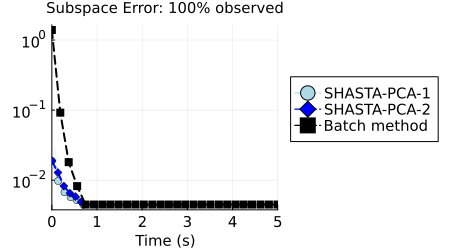

In [28]:
missing_rate = Int(round((1-missing)*100))
p1 = plottimetraces(errs,times,labels,colors,markers,interval,alph,figsize,fontsize,"Subspace Error: $missing_rate% observed","Time (s)",:outerright,:log)
# hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")
# xlims!(0,300)
xlims!(0,5)
plot!(size=(450,250))
file = "/Users/kgilman/Desktop/streaming-hppca/Streaming-Heteroscedastic-PPCA/shasta_results/batch_subspace-distance-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".pdf"
# savefig(p1,file)
plot(p1)

In [29]:
Mstream.λ

3-element Vector{Float64}:
 3.583443324010878
 1.4292380126772675
 1.1447352949726597

In [30]:
Mbatch.λ

3-element Vector{Float64}:
 1.5985773996935182
 0.8629588685246073
 0.6180214476334028

In [31]:
Mstream.v

2-element Vector{Float64}:
 0.00014701107423113297
 0.009957806774257259

In [32]:
Mstream2.v

2-element Vector{Float64}:
 0.00010640235799942221
 0.0099391462229055

In [33]:
Mbatch.v

2-element Vector{Float64}:
 9.98439369031803e-5
 0.009941044595868925

In [34]:
abs.(Mstream.v - Mtrue.v) ./ Mtrue.v

2-element Vector{Float64}:
 0.4701107423113296
 0.0042193225742741605

In [35]:
abs.(Mstream2.v - Mtrue.v) ./ Mtrue.v

2-element Vector{Float64}:
 0.06402357999422205
 0.006085377709449946

In [36]:
abs.(Mbatch.v - Mtrue.v) ./ Mtrue.v

2-element Vector{Float64}:
 0.0015606309681971025
 0.005895540413107525

### Lambda recovery

In [ ]:
d, n, v, λ = 100, [500,2000], [1e-4,1e-2], [4,2,1]
k, L = length(λ), length(v)
khat = k;

num_trials = 1

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]


### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

w = 1
cf = 0.1
cv = 0.1
δ = 0.1

online = false
lrparams = LearningRateParams(w,cf,cv)

λ = 1.0

batch_models = []
shasta_models = []
petrels_models = []

missing_rate = [0, 0.25, 0.5, 0.75]
for missing in ProgressBar(missing_rate)

    Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
    Y = [Ω[l] .* Ytrue[l] for l in 1:L]
    
    ### Streaming-setup
    Ymat_true = hcat([Ytrue[l] for l=1:L]...)
    Ymat = hcat([Y[l] for l=1:L]...)
    vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
    groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
    ΩY = abs.(Ymat) .> 0

    dataIdx = randperm(sum(n))
    Ymat = Ymat[:,dataIdx]
    Ymat_true = Ymat_true[:,dataIdx]
    ΩY = ΩY[:,dataIdx]
    groups = groups[dataIdx]

    Ltrue = Ωloglikelihood2(Mtrue,Ytrue,Ω)
    stats_fcn(M) = Ωloglikelihood2(M,Ytrue,Ω) - Ltrue
    
    ### Batch
    
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mbatch = deepcopy(M0)
    Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,niters,Fmeasure,stats_fcn)
    
#     ### SHASTA
#     Mshasta = deepcopy(M0)
#     Mshasta, Yrec, stats_log_shasta, err_log_shasta, time_log_shasta = SHASTA_PCA2(Mshasta,Ymat,ΩY,groups,lrparams,δ,Fmeasure,stats_fcn,online,250)
    
#     ### PETRELS
#     Mpetrels = deepcopy(M0)
#     Mpetrels, Yrec, stats_log_petrels, err_log_petrels, time_log_petrels = PETRELS(Mpetrels,Ymat,ΩY,λ,δ,Fmeasure,stats_fcn,250)
    
    push!(batch_models,Mbatch)
#     push!(shasta_models,Mshasta)
#     push!(petrels_models,Mpetrels)
    
end



In [ ]:
plot(legend=:outerright)

markers = [:circle, :diamond, :utriangle]
for j=1:k
    plot!([model.λ[j] for model in batch_models],linecolor=:red,markercolor=:red,marker=markers[j],label="Batch: lambda $j")
#     plot!([model.λ[j] for model in shasta_models],linecolor=:blue,markercolor=:blue,marker=markers[j],label="SHASTA: lam: $j")
#     plot!([model.λ[j] for model in petrels_models],linecolor=:orange,label="PETRELS: lambda $j")
end

plot!()

### Visualization

In [ ]:
function Ωloglikelihood(M,Y,Ω)
    L = length(Y)
    n = [size(Y[l])[2] for l=1:L]
    F = M.F
    value = 0
    for l=1:L
        for i=1:n[l]
            idx = findall(>(0), Ω[l][:,i])
            yΩ = Y[l][idx,i]
            FΩ = F[idx,:]
            Mtl = inv(FΩ*FΩ' + M.v[l]*I)
            value += log(det(Mtl)) - yΩ'*Mtl*yΩ
        end
    end
    return value
end

In [ ]:
d, n, v, λ = 50, [20,80], [1e-4,1e-1], [4,2]
k, L = length(λ), length(v)
khat = k;

num_trials = 10

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.5
# missing = 0.7
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) for l=1:L]
Ynoisy = [Ytrue[l] + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ynoisy[l] for l in 1:L]

In [ ]:
Yfull = hcat(Ynoisy...);
Yfull[Yfull .== 0] .= -Inf
fontsize = 18;
p1 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),right_margin=5mm)
heatmap!(p1,Yfull,aspect_ratio=:equal,c=:ice,colorbar=false,clims=(-2,2))
title!("Corrupted with Heterogeneous Noise")
savefig(p1,"visuals/full_hetero_mtx.pdf")
plot!()

In [ ]:
Ymiss = hcat(Y...)
Ymiss[Ymiss .== 0] .= -Inf
p2 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),right_margin=5mm)
heatmap!(p2,Ymiss,aspect_ratio=:equal,c=:ice,colorbar=false,clims=(-2,2))
title!("Heterogeneous noise with 50% missing")
savefig(p2,"visuals/missing_hetero_mtx.pdf")
plot!()

#### Run batch algorithm for missing data

In [ ]:
include("batchHPPCACompletion.jl")

In [ ]:
function homppca(Y,k)
    Yf = reduce(hcat,Y)
    n, L = size(Yf,2), length(Y)
    Uh, s, _ = svd(Yf)
    λh = abs2.(s)./n
    λb = mean(λh[k+1:end])
    HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L))
end

In [ ]:
# Mbatch = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mbatch = homppca(Y,khat)

function Fmeasure(M)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

Mtrue = HePPCATModel(U,λ,I(k),v)

Ltrue = Ωloglikelihood(Mtrue,Ynoisy,Ω)
stats_fcn(M) = Ωloglikelihood(M,Ynoisy,Ω) - Ltrue


# Ltrue = loglikelihood(Mtrue,Ynoisy)
# stats_fcn(M) = loglikelihood(M,Ynoisy) - Ltrue

niters = 100

Mbatch, batch_stats_log, batch_err_log, batch_time_log = batchHPPCACompletion(Mbatch,Y,Ω,niters,Fmeasure,stats_fcn)

In [ ]:
Mheppcat = heppcat(Y,khat,100)

In [ ]:
plot(batch_stats_log,figsize=(300,300),label="Modeled for Missing Data")
hline!([stats_fcn(Mheppcat)],label="HePPCAT")
plot!(legend=:bottomright)
title!("Log-likelihood")
# ylims!(-1000,Inf)

In [ ]:
Mbatch.v

In [ ]:
Mheppcat.v

In [ ]:
norm(Mheppcat.F*Mheppcat.F' - Mbatch.F*Mbatch.F') / norm( Mbatch.F*Mbatch.F')

In [ ]:
Fmeasure(Mheppcat)

In [ ]:
Fmeasure(Mbatch)

In [ ]:
plot(batch_err_log,yaxis=:log)
hline!([Fmeasure(Mheppcat)])

In [ ]:
# Fh = Mbatch.F
Fh = Mheppcat.U
Yimpute1 = [zeros(d,n[l]) for l=1:L]
Yimpute2 = [zeros(d,n[l]) for l=1:L]
for l=1:L
    for i=1:n[l]
        idx = findall(>(0), Ω[l][:,i])
        Yimpute1[l][:,i] = Fh*inv(Fh[idx,:]'*Fh[idx,:] + Mbatch.v[l]*I)*Fh[idx,:]'*Y[l][idx,i]
        Yimpute2[l][:,i] = Fh*inv(Fh[idx,:]'*Fh[idx,:])*Fh[idx,:]'*Y[l][idx,i]
    end
end

Yimpute1 = hcat(Yimpute1...)
Yimpute2 = hcat(Yimpute2...)

Ytruefull = hcat(Ytrue...);

#### full imputation NRMSE

In [ ]:
norm(Yimpute1 - Ytruefull) ./ norm(Ytruefull)

In [ ]:
norm(Yimpute2 - Ytruefull) ./ norm(Ytruefull)

#### group 1

In [ ]:
norm(Yimpute1[:,n[1]] - Ytruefull[:,n[1]]) ./ norm(Ytruefull[:,n[1]])

In [ ]:
norm(Yimpute2[:,n[1]] - Ytruefull[:,n[1]]) ./ norm(Ytruefull[:,n[1]])

#### group 2

In [ ]:
norm(Yimpute1[:,n[1]+1:n[2]] - Ytruefull[:,n[1]+1:n[2]]) ./ norm(Ytruefull[:,n[1]+1:n[2]])

In [ ]:
norm(Yimpute2[:,n[1]+1:n[2]] - Ytruefull[:,n[1]+1:n[2]]) ./ norm(Ytruefull[:,n[1]+1:n[2]])

In [ ]:
p3 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),right_margin=5mm)
heatmap!(p3,Yimpute1,aspect_ratio=:equal,c =:ice,colorbar=false,clims=(-2,2))
title!("Completed and denoised")
savefig(p3,"visuals/imputed_hetero_mtx.pdf")
plot!()

In [ ]:
p4 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),right_margin=5mm)
heatmap!(p4,Ytruefull,aspect_ratio=:equal,c =:ice,colorbar=false,clims=(-2,2))
title!("True data")
savefig(p4,"visuals/true_mtx.pdf")
plot!()

In [ ]:
p5 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),right_margin=10mm)
heatmap!(p5,Yimpute1 - Ytruefull,aspect_ratio=:equal,c =:ice,colorbar=true)
title!("Differences")
# savefig(p4,"visuals/true_mtx.pdf")
plot!()

### Unit testing

In [ ]:
M0 = HePPCATModel(randn(d,k),rand(L));
M1 = deepcopy(M0)
M2 = deepcopy(M0)

In [ ]:
function updateF1!(M::HePPCATModel,Y)
    n, L = size.(Y,2), length(Y)
    Λ = Diagonal(M.λ)
    Γ = [inv(Λ + M.v[l]*I) for l in 1:L]
    Z = [Γ[l]*sqrt(Λ)*M.U'*Y[l] for l in 1:L]
    num = sum(Y[l]*Z[l]'/M.v[l] for l in 1:L)
    den = sum(Z[l]*Z[l]'/M.v[l] + n[l]*Γ[l] for l in 1:L)

    F = svd((num / den) * M.Vt)
    M.U .= F.U
    M.λ .= F.S.^2
    M.Vt .= F.Vt
    return M
end

In [ ]:
function updateF2!(M,Y,Ω)
	F  = M.F
	k = size(F,2)
	v = M.v
	L = length(Y)
	n = [size(Yl,2) for Yl in Y]
    
    R = [zeros(k,k) for _=1:d]
	s = [zeros(k) for _=1:d]

	for l=1:L 
		for i=1:n[l]
			Ωli = findall(>(0), Ω[l][:,i])
			FΩ = F[Ωli,:]
			yΩ = Y[l][Ωli,i]
			Mtli = inv(FΩ'*FΩ + v[l]*I)
            ztli = Mtli*FΩ'*yΩ
            R[Ωli] += [1/v[l] * (ztli*ztli' + v[l]*Mtli) for j in Ωli]
            s[Ωli] += [1/v[l] * Y[l][j,i]*ztli for j in Ωli]
		end
	end

	### Update F

	Fhat = hcat(computefj.(Ref(R),Ref(s),1:d)...)'
	Fhat = svd(Fhat)
    M.U .= Fhat.U
    M.λ .= Fhat.S.^2
    M.Vt .= Fhat.Vt

    return M

end

function computefj(R,s,j)
    return inv(R[j])*s[j]
end


In [ ]:
M1 = updateF1!(M1,Y)
M2 = updateF2!(M2,Y,Ω)

In [ ]:
norm(M2.F - M1.F)

#### Unit test F update

In [ ]:
# Random.seed!(1)
# d, n, v, λ = 100, [200,800], [1,4], [4,2,1]
d, n, v, λ = 100, [200,800], [1e-2,1e-1], [4,2,1]
k, L = length(λ), length(v)
khat = k;

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.0
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) for l=1:L]
Ynoisy = [Ytrue[l] + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ynoisy[l] for l in 1:L]

Mtrue = HePPCATModel(F,v)
Ltrue = loglikelihood(Mtrue,Y)
stats_fcn(M) = loglikelihood(M,Y) - Ltrue

In [ ]:
M0 = HePPCATModel(randn(d,k),rand(L));
M1 = deepcopy(M0)
M2 = deepcopy(M0)

objFxn1 = []
objFxn2 = []
for t = 1:300
    updatev1!(M1,Y)
    updateF1!(M1,Y)
    
    updatev2!(M2,Y,Ω)
    updateF2!(M2,Y,Ω)
    
    push!(objFxn1,stats_fcn(M1))
    push!(objFxn2,stats_fcn(M2))
end

Mheppcat = heppcat(Y,k,100)


In [ ]:
plot(legend=:bottomright)
plot!(objFxn1,label="HePPCAT (test)")
plot!(objFxn2,label="test")
hline!([loglikelihood(Mheppcat,Y)- Ltrue],label="HePPCAT")
# ylims!(-1000,Inf)

In [ ]:
objFxn1[end]

In [ ]:
objFxn2[end]

In [ ]:
M1.λ

In [ ]:
M2.λ

In [ ]:
Mheppcat.λ

#### Unit test v updates

HePPCAT variance EM updates

In [ ]:
function updatev1!(M::HePPCATModel,Y)
    for (l,Yl) in enumerate(Y)
        M.v[l] = updatevl(M.v[l],M.U,M.λ,Yl)
    end
    return M
end


function updatevl(vl,U,λ,Yl)
    d, k = size(U)
    nl = size(Yl,2)

    UYl = [sum(abs2,Yl'U[:,j]) for j in 1:k]
    UYl0 = nonnegative(sum(abs2,Yl)-sum(UYl))
    β = [j == 0 ? UYl0/nl : UYl[j]/nl for j in 0:k]
    γ = [j == 0 ? zero(eltype(λ)) : λ[j] for j in 0:k]
    
    ρ = sum((oneunit(eltype(λ)).-γ./(γ.+vl)).^2 .* β) + vl*sum(λ./(λ.+vl))
    return ρ/d
end

nonnegative(x) = max(zero(x),x)

In [ ]:
Batch Completion variance EM updates

In [ ]:
function updatev2!(M,Y,Ω)
	F = M.F
	v = M.v

	L = length(Y)
	n = [size(Yl,2) for Yl in Y]

	for l=1:L 
		ρtl = 0
        θ = 0
        α = 0
		for i=1:n[l]
			# Ωli = Ωidx[l][i]
			Ωli = findall(>(0), Ω[l][:,i])
			FΩ = F[Ωli,:]
			# yΩ = Y[l][:,i][Ωli]
			yΩ = Y[l][Ωli,i]
			Mtli = inv(FΩ'*FΩ + v[l]*I)
			ztli = Mtli*FΩ'*yΩ
			ρtl += 2*yΩ'*(FΩ*ztli) - (norm(FΩ*ztli)^2 + v[l]*tr((FΩ'*FΩ)*Mtli))
            θ += length(Ωli)
            α += norm(yΩ)^2
		end
		M.v[l] = (α - ρtl) / θ
	end

	return M

end

In [ ]:
M0 = HePPCATModel(randn(d,k),rand(L));
M1 = deepcopy(M0)
M2 = deepcopy(M0)

for t=1:100
    updatev1!(M1,Y)
    updatev2!(M2,Y,Ω)
end

In [ ]:
norm(M1.v - M2.v)

## Outlier Detection

In [ ]:
d, n, v, λ = 50, [20,80], [1e-4,1e-1], [4,2]
k, L = length(λ), length(v)
khat = k;

num_trials = 10

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.0
# missing = 0.7
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) for l=1:L]
Ynoisy = [Ytrue[l] + sqrt(v[l])*randn(d,n[l]) for l in 1:L]

S = randn(d,3)
SΩ = (rand(d,3) .> 0.0)
S = S.*SΩ
Ynoisy[1][:,10] += S[:,1]
Ynoisy[2][:,20] += S[:,2]
Ynoisy[2][:,60] += S[:,3]
Y = [Ω[l] .* Ynoisy[l] for l in 1:L]
Ycorrupted = hcat(Y...)
Ysingle = [Ycorrupted[:,i] for i=1:size(Ycorrupted)[2]];

In [ ]:
p4 = plot(figsize=(1000,3000),xtickfont=font(fontsize), 
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),bottom_margin=5mm,right_margin=5mm,
    xlabel="Sample")
heatmap!(p4,Ycorrupted,aspect_ratio=:equal,c =:ice,colorbar=false,clims=(-2,2))
title!("Corrupted data")
savefig(p4,"visuals/corrupted_data.pdf")
plot!()

In [ ]:
Mcorrupt = heppcat(Ysingle,k,50)

In [ ]:
p5 = scatter(Mcorrupt.v,label="",xtickfont=font(fontsize), yaxis=:log,
    ytickfont=font(fontsize), 
    guidefont=font(fontsize), 
    legendfont=font(fontsize),
    titlefont=font(fontsize),bottom_margin=5mm,
    title="Estimated HePPCAT Variances (L=n)",
    xticks=0:20:120,
    ylabel="Variance",xlabel="Data sample",size=(600,400))
ylims!(1e-6,1e1)
savefig(p5,"visuals/corrupted_data_variance_estimates.pdf")
plot!()